# Weak Formulation

Equation (b) is a vector equation, so really it is two or three equations involving multiple components of $\vec{j}$. We want to work with a single scalar equation, allow for anisotropic physical properties, and potentially work with non-axis-aligned meshes — how do we do this?! We can use the **weak formulation** where we take the inner product ($\int \vec{a} \cdot \vec{b} dv$) of the equation with a generic face function, $\vec{f}$. This reduces requirements of differentiability on the original equation and also allows us to consider tensor anisotropy or curvilinear meshes (Haber 2014).

## Scalar equations only, please

In Figure 5, we visually walk through the discretization of equation (b). On the left hand side, a dot product requires a *single* cartesian vector, $[\mathbf{j_x, j_y}]$. However, we have a $j$ defined on each face (2 $j_x$ and 2 $j_y$ in 2D!). There are many different ways to evaluate this inner product: we could approximate the integral using trapezoidal, midpoint or higher order approximations. A simple method is to break the integral into four sections (or 8 in 3D) and apply the midpoint rule for each section using the closest $\mathbf{j}$ components to compose a cartesian vector. A $\mathbf{P}_i$ matrix (size 2 × 4) is used to pick out the appropriate faces and compose the corresponding vector (these matrices are shown with colors corresponding to the appropriate face in the figure). On the right hand side, we use a vector identity to integrate by parts. The second term will cancel over the entire mesh (as the normals of adjacent cell faces point in opposite directions) and $\phi$ on mesh boundary faces are zero by the Dirichlet boundary condition. This leaves us with the  divergence, [which we already know how to do](divergence.ipynb)!

<img src="images/WeakFormulation.png" style="width:75%;text-align:center">

<p style="text-align:center;">
**Figure 5**: Discretization using the weak formulation and inner products.
</p>

The final step is to recognize that, now discretized, we can cancel the general face function $\mathbf{f}$ and transpose the result (for convention's sake):

$$
\frac{1}{4}\sum_{i=1}^{4} \mathbf{P}_i^\top \sqrt{v} \boldsymbol{\Sigma}^{-1} \sqrt{v} \mathbf{P}_i \mathbf{j} = \mathbf{D}^\top v \phi
$$

# Implementation

We will start by using a SimPEG Mesh that only has a single cell.

In [1]:
%matplotlib inline
from SimPEG import Mesh
import numpy as np
import matplotlib.pyplot as plt

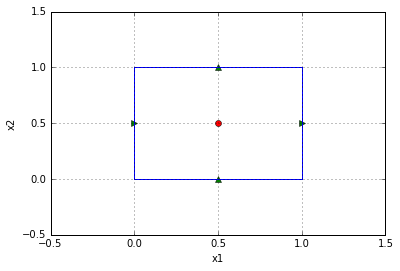

In [2]:
fig, ax = plt.subplots(1)
mesh = Mesh.TensorMesh([1,1])
mesh.plotGrid(ax=ax,centers=True,faces=True)
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.5,1.5);

The figure above is of a single cell, which in 2D has four faces (the green triangles). Two of these are pointed in the x direction and two in the y direction.

For this single cell, we need our projection matrices to pick out four cartesian vectors that we will then use in evaluating the full integral.

Instead of creating the code from scratch in this notebook, we will leverage some of the internal functions that are in SimPEG. The code is straight forward, but can get a little bit intricate when working with multiple dimensions and indexing in a generalized way (i.e. works for all of the meshes).

If you ever want to see the exact code that is executed in a function, you can use two question marks (one for the docs only). For example, execute **`mesh._getFacePxx??`** and Jupyter will show you more than you ever wanted. :)

In [3]:
# mesh._getFacePxx??

This function creates the P matrices that we need. The matrix just pick out the appropriate faces and are used later on to evaluate our full integral.

In [4]:
# face-x minus side and the face-y minus side
P1 = mesh._getFacePxx()('fXm','fYm')
print( P1.todense() )

[[ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]]


We can create and plot all of the matrices that were in Figure 5:

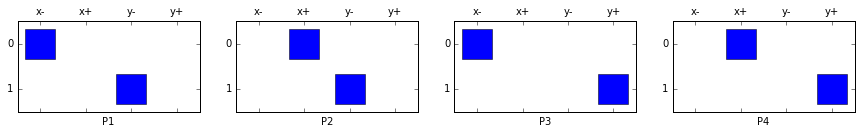

In [5]:
P1 = mesh._getFacePxx()('fXm','fYm')
P2 = mesh._getFacePxx()('fXp','fYm')
P3 = mesh._getFacePxx()('fXm','fYp')
P4 = mesh._getFacePxx()('fXp','fYp')
fig, ax = plt.subplots(1,4, figsize=(15,3))
def plot_projection(ii, ax, P):
    ax.spy(P, ms=30)
    if P.shape[1]==4:
        ax.set_xticks(range(4))
        ax.set_xticklabels(('x-','x+','y-','y+'))
    ax.set_xlabel('P{}'.format(ii+1))
map(plot_projection, range(4), ax, (P1, P2, P3, P4));

This assumes that we unwrapped our face vectors in certain way and they are ordered [xfaces, yfaces].

# All the cells!

When we move to more cells the visualization of the matrix is not as clear, so instead we will show a connection from each cell center to the x and y faces that are selected by the P matrix.

In [6]:
mesh = Mesh.TensorMesh([3,4])

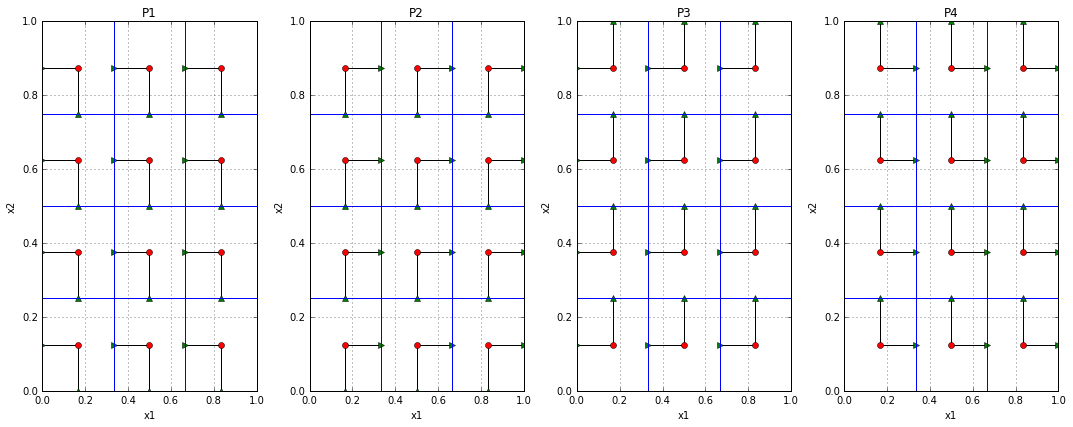

In [7]:
P1 = mesh._getFacePxx()('fXm','fYm')
P2 = mesh._getFacePxx()('fXp','fYm')
P3 = mesh._getFacePxx()('fXm','fYp')
P4 = mesh._getFacePxx()('fXp','fYp')
fig, ax = plt.subplots(1,4, figsize=(15,6))
def plot_projection(ii, ax, P):
    x = P * np.r_[mesh.gridFx[:,0], mesh.gridFy[:,0]]
    y = P * np.r_[mesh.gridFx[:,1], mesh.gridFy[:,1]]
    xx, xy = x[:mesh.nC], x[mesh.nC:]
    yx, yy = y[:mesh.nC], y[mesh.nC:]
    ax.plot(np.c_[xx, mesh.gridCC[:,0], xx*np.nan].flatten(), np.c_[yx, mesh.gridCC[:,1], yx*np.nan].flatten(), 'k-')
    ax.plot(np.c_[xy, mesh.gridCC[:,0], xy*np.nan].flatten(), np.c_[yy, mesh.gridCC[:,1], yy*np.nan].flatten(), 'k-')
    ax.plot(xx, yx, 'g>')
    ax.plot(xy, yy, 'g^')
    mesh.plotGrid(ax=ax, centers=True)
    ax.set_title('P{}'.format(ii+1))
map(plot_projection, range(4), ax.flatten(), (P1, P2, P3, P4));
plt.tight_layout()

Each cell (the center is the red dot) has two faces that it uses, one x component and one y component.

The four $P$ matrices are assembled and summed in the **getFaceInnerProduct** code using this formula:


$$
\mathbf{M}_f(\sigma) = \frac{1}{4}\sum_{i=1}^{4} \mathbf{P}_i^\top \sqrt{v} \boldsymbol{\Sigma}^{-1} \sqrt{v} \mathbf{P}_i
$$

This function takes a sigma variable which can have any sort of anisotropy:

$$
\begin{align}\begin{aligned}\begin{split}\vec{\mu} = \left[\begin{matrix} \mu_{1} & 0 \\ 0 & \mu_{1} \end{matrix}\right]\end{split}\\\begin{split}\vec{\mu} = \left[\begin{matrix} \mu_{1} & 0 \\ 0 & \mu_{2} \end{matrix}\right]\end{split}\\\begin{split}\vec{\mu} = \left[\begin{matrix} \mu_{1} & \mu_{3} \\ \mu_{3} & \mu_{2} \end{matrix}\right]\end{split}\end{aligned}\end{align}
$$

The matrices that are produced by this function can be seen below!

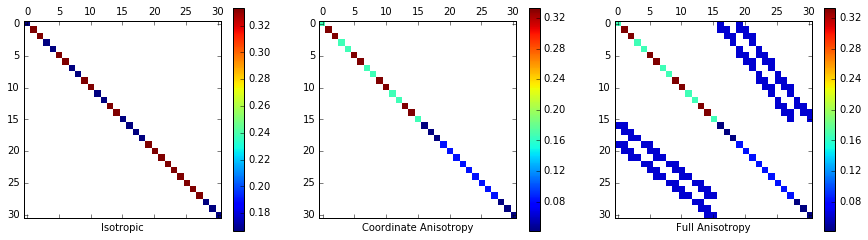

In [8]:
isotropic       = np.ones(mesh.nC)*4
anisotropic_vec = np.r_[np.ones(mesh.nC)*4, np.ones(mesh.nC)]
anisotropic     = np.r_[np.ones(mesh.nC)*4, np.ones(mesh.nC), np.ones(mesh.nC)*3]
Mf_sig_i = mesh.getFaceInnerProduct(isotropic)
Mf_sig_v = mesh.getFaceInnerProduct(anisotropic_vec)
Mf_sig_a = mesh.getFaceInnerProduct(anisotropic)
clim = (
    np.min(map(np.min, (Mf_sig_i.data, Mf_sig_v.data, Mf_sig_a.data))),
    np.max(map(np.max, (Mf_sig_i.data, Mf_sig_v.data, Mf_sig_a.data)))
)
fig, ax = plt.subplots(1,3, figsize=(15,4))
def plot_spy(ax, Mf, title):
    dense = Mf.toarray()
    dense[dense == 0] = np.nan
    ms = ax.matshow(dense)#, clim=clim)
    plt.colorbar(ms, ax=ax)
    ax.set_xlabel(title)
map(plot_spy, ax, (Mf_sig_i, Mf_sig_v, Mf_sig_a), ('Isotropic', 'Coordinate Anisotropy', 'Full Anisotropy'));

In the last figure you can see that there is coupling between the cells in x and y due to the non-coordinate aligned anisotropy. This will make the matrix system harder to solve when we try to invert it!

# Ok, but does it work?

Unfortunately the testing of the innerproducts is not that visual. We need to make sure that the integral of some made up function evaluates to the correct value.

So to make something up, and integrate it, we will use **sympy**!

We will evaluate the integral:
$$
\int_0^1 \int_0^1 \sigma(x,y) \vec{j}(x,y) \cdot \vec{j}(x,y) \quad dx dy
$$
by making up some ridiculous functions.

In [9]:
import sympy
from sympy.abc import x, y

# Here we will make up some j vectors that vary in space
j = sympy.Matrix([
    x**2+y*5,
    (5**2)*x+y*5
])

# Create an isotropic sigma vector
Sig = sympy.Matrix([
    [x*y*432/1163,      0      ],
    [     0      , x*y*432/1163]
])

# Do the inner product!
jTSj = j.T*Sig*j
ans  = sympy.integrate(sympy.integrate(jTSj, (x,0,1)), (y,0,1))[0] # The `[0]` is to make it an int.

print( "It is trivial to see that the answer is {}.".format(ans) )

It is trivial to see that the answer is 42.


Wonderful. Everything seems right in the world with that answer. Next step is to sub in the locations of the grid on both the faces in x and y as well as the cell centers.

In [10]:
def get_vectors(mesh):
    """Gets the vectors sig and [jx, jy] from sympy."""
    f_jx  = sympy.lambdify((x,y), j[0], 'numpy')
    f_jy  = sympy.lambdify((x,y), j[1], 'numpy')
    f_sig = sympy.lambdify((x,y), Sig[0], 'numpy')
    jx  = f_jx(mesh.gridFx[:,0], mesh.gridFx[:,1])
    jy  = f_jy(mesh.gridFy[:,0], mesh.gridFy[:,1])
    sig = f_sig(mesh.gridCC[:,0], mesh.gridCC[:,1])
    return sig, np.r_[jx, jy]

Using these vectors ($\sigma$ and $\mathbf{j}$) we can evaluate the result on our mesh

In [11]:
n = 5 # get's better if you add cells!
mesh = Mesh.TensorMesh([n,n])
sig, jv = get_vectors(mesh)
Msig = mesh.getFaceInnerProduct(sig)
numeric_ans = jv.T.dot(Msig.dot(jv))
print( "Numerically we get {}.".format(numeric_ans) )

Numerically we get 41.1891755804.


That is pretty close, but to be rigorous we should look at the order of the convergence which should be $\mathcal{O}(h^2)$.

SimPEG has a number of testing functions for 
[derivatives](http://docs.simpeg.xyz/content/api_core/api_Tests.html#SimPEG.Tests.checkDerivative)
and 
[order of convergence](http://docs.simpeg.xyz/content/api_core/api_Tests.html#SimPEG.Tests.OrderTest) 
that make this pretty simple!

In [12]:
import sys
import unittest
from SimPEG.Tests import OrderTest

class Testify(OrderTest):
    meshDimension = 2
    def getError(self):
        sig, jv = get_vectors(self.M)
        Msig = self.M.getFaceInnerProduct(sig)
        return float(ans) - jv.T.dot(Msig.dot(jv))
    def test_order(self):
        self.orderTest()

# This just runs the unittest:
suite = unittest.TestLoader().loadTestsFromTestCase( Testify )
unittest.TextTestRunner().run( suite );

.


uniformTensorMesh:  Order Test
_____________________________________________
   h  |    error    | e(i-1)/e(i) |  order
~~~~~~|~~~~~~~~~~~~~|~~~~~~~~~~~~~|~~~~~~~~~~
   4  |  1.27e+00   |
   8  |  3.17e-01   |   3.9942    |  1.9979
  16  |  7.93e-02   |   3.9985    |  1.9995
  32  |  1.98e-02   |   3.9996    |  1.9999
---------------------------------------------
Awesome, Rowan, just awesome.




----------------------------------------------------------------------
Ran 1 test in 0.028s

OK


These basic operations on the mesh for inner products and differential operators are core pieces of SimPEG, and they need to be tested continuously to ensure that no one has broken them!

On every single change to the SimPEG codebase many hours of testing are completed!

If you would like to browse through the results of 424 tests that are run on the mesh classes you can see them here:

https://travis-ci.org/simpeg/simpeg/jobs/148608973

# Next up ...

In the [next notebook](all_together_now.ipynb) we will use our knowledge of the [mesh](mesh.ipynb) and the [divergence](divergence.ipynb) implementations to bring the DC resistivity equations together and show some pretty figures!